### Implementation "A Learned Representation for Artistic Style"
##### paper : https://arxiv.org/abs/1610.07629

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
import numpy as np
import os
from datetime import datetime

In [3]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
torch.cuda.set_device(1)

In [4]:
imsize = 256
cropsize = 240
eps =1e-5

In [5]:
content_layers = [15]
style_layers = [3, 8, 15, 22]

In [6]:
style_layer_weights = [1/len(style_layers)]*len(style_layers)
content_layer_weights = [1/len(content_layers)]*len(content_layers)

#### image utils

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

loader = transforms.Compose([
    transforms.Scale(imsize),
    transforms.RandomCrop(cropsize),
    transforms.ToTensor(),  # transform it into a torch tensor: H x W x 3 in range of (0, 255) to 3 x H x W in range of (0.0, 1.0)
    normalize, 
    transforms.Lambda(lambda image : image.unsqueeze(0))
    ])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image)
    
    return image


denormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                   std=[1.0/0.229, 1.0/0.224, 1.0/0.225])

unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    if len(image.size()) == 4:
        image = image.squeeze(0)
    image = denormalize(image)  # denormalize with mean and std: x = (x+mean/std)*std
    image.clamp_(0.0, 1.0)  # clamping pixel values in range of (0.0, 1.0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

#### conditional instance normalization module

In [8]:
class CIN(nn.Module):
    
    def __init__(self, style_num, channel):
        super(CIN, self).__init__()
        self.normalize = nn.InstanceNorm2d(channel, affine=False)
        
        self.offset = nn.Parameter(0.01*torch.randn(1, style_num, channel))
        self.scale = nn.Parameter(1+0.01*torch.randn(1, style_num, channel))
        
    def forward(self, x, style_codes):
        b, c, h, w = x.size()
        
        x = self.normalize(x)
        
        gamma = torch.sum(self.scale*style_codes, dim=1).view(b,c,1,1)
        beta = torch.sum(self.offset*style_codes, dim=1).view(b,c,1,1)
        
        x = x*gamma + beta
                
        return x.view(b, c, h, w)

#### convolution and cin module

In [9]:
class ConvWithCIN(nn.Module):
    def __init__(self, style_num, in_ch, out_ch, stride, activation, ksize):
        super(ConvWithCIN, self).__init__()
        pad= ksize//2
        # padding
        self.padding = nn.ReflectionPad2d(pad)
        
        # conv
        self.conv = nn.Conv2d(in_ch, out_ch, ksize, stride)
        
        # cin
        self.cin = CIN(style_num, out_ch)
        if use_cuda:
            self.cin = self.cin.cuda()
        
        # activatoin 
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "linear":
            self.activation = lambda x : x
            
    def forward(self, x, style_codes):
        x = self.padding(x)
        x = self.conv(x)
        x = self.cin(x, style_codes)
        x = self.activation(x)
        
        return x

#### residual block module

In [10]:
class ResidualBlock(nn.Module):
    
    def __init__(self, style_num, in_ch, out_ch):
        super(ResidualBlock, self).__init__()
        
        self.conv_with_cin1 = ConvWithCIN(style_num, in_ch, out_ch, 1, "relu", 3)
        self.conv_with_cin2 = ConvWithCIN(style_num, out_ch, out_ch, 1, "linear", 3)
        
    def forward(self, x, style_codes):
        out = self.conv_with_cin1(x, style_codes)
        out = self.conv_with_cin2(out, style_codes)

        return x+out

#### upsampling block module

In [11]:
class UpsamleBlock(nn.Module):
    
    def __init__(self, style_num, in_ch, out_ch):
        super(UpsamleBlock, self).__init__()
        self.conv_with_cin = ConvWithCIN(style_num, in_ch, out_ch, 1, "relu", 3)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
    def forward(self, x, style_codes):
        x = self.upsample(x)
        x = self.conv_with_cin(x, style_codes)
        
        return x

#### style transfer network

In [12]:
class TransferNetwork(nn.Module):
    def __init__(self, style_num):
        super(TransferNetwork, self).__init__()
        self.style_num = style_num
        
        self.conv_with_cin1 = ConvWithCIN(self.style_num,  3, 32, 1, 'relu', 9)
        self.conv_with_cin2 = ConvWithCIN(self.style_num, 32, 64, 2, 'relu', 3)
        self.conv_with_cin3 = ConvWithCIN(self.style_num, 64, 128, 2, 'relu', 3)
        
        self.residual1 = ResidualBlock(self.style_num, 128, 128)
        self.residual2 = ResidualBlock(self.style_num, 128, 128)
        self.residual3 = ResidualBlock(self.style_num, 128, 128)
        self.residual4 = ResidualBlock(self.style_num, 128, 128)
        self.residual5 = ResidualBlock(self.style_num, 128, 128)
        
        self.upsampling1 = UpsamleBlock(self.style_num, 128, 64)
        self.upsampling2 = UpsamleBlock(self.style_num, 64, 32)
        
        self.conv_with_cin4 = ConvWithCIN(self.style_num, 32, 3, 1, 'linear', 9)      
        
    def forward(self, x, style_codes):
        x = self.conv_with_cin1(x, style_codes)
        x = self.conv_with_cin2(x, style_codes)
        x = self.conv_with_cin3(x, style_codes)
        
        x = self.residual1(x, style_codes)
        x = self.residual2(x, style_codes)
        x = self.residual3(x, style_codes)
        x = self.residual4(x, style_codes)
        x = self.residual5(x, style_codes)
        
        x = self.upsampling1(x, style_codes)
        x = self.upsampling2(x, style_codes)
        
        x = self.conv_with_cin4(x, style_codes)
        
        return x

#### feature extraction

In [13]:
def extract_features(model, x, style_layers, content_layers):
    style_features = list()
    content_features = list()
    for i in range(max(style_layers+content_layers)+1):
        x = model[i](x)
        if i in style_layers:
            style_features.append(x)
        if i in content_layers:
            content_features.append(x)
            
    return style_features, content_features

#### loss calculation

In [14]:
def gram(x):
    b, c, h, w = x.size()
    flatten = x.view(b, c, h*w)
    G = torch.bmm(flatten, flatten.transpose(1,2))
    
    return G.div(h*w)

In [15]:
criterion = nn.MSELoss(size_average=True)

In [16]:
def calc_style_loss(features, targets, weights):
    loss= 0
    for f, t, w in zip(features,targets, weights):
        loss += w * criterion(gram(f), gram(t))
    return loss

In [17]:
def calc_content_loss(features, targets, weights):
    loss = 0
    for f, t, w in zip(features, targets, weights):
        loss += w * criterion(f, t)
    return loss

In [18]:
def calc_tv_loss(x):
    diff_w = x[:,:,:,:-1] - x[:,:,:,1:]
    diff_h = x[:,:,:-1,:] - x[:,:,1:,:]
    
    loss = torch.sum(torch.abs(diff_w))
    loss += torch.sum(torch.abs(diff_h))
    
    b = x.size(0)
    return loss.div(b)

#### training

In [19]:
spath = '/home/minsung/Test_Images/style32images/'
slist = sorted(os.listdir(spath))
print("style image set : ",len(slist))

cpath = '/home/minsung/COCO_DATASET/train2014_256/'
clist = os.listdir(cpath)
print("content image set : ",len(clist))

style image set :  32
content image set :  82783


In [20]:
def learn_style_transfer_network(STN, vgg, 
                                 default_slayers=style_layers, default_clayers=content_layers,
                                 style_layer_weights = style_layer_weights, content_layer_weights = content_layer_weights,
                                 style_weight = 50.0, content_weight=1.0, tv_weight=1e-5,
                                learning_rate = 1e-3, batch_size = 8, epochs=4):
    
    optimizer = optim.Adam(STN.parameters(), lr = learning_rate)
    
    style_loss_log = list()
    content_loss_log = list()
    tv_loss_log = list()
    total_loss_log = list()
    
    for epoch in range(epochs):
        
        # iterate for small size , datasets/batch size
        for iteration in range(int(len(clist)//batch_size)):
            
            temp_simg = []
            temp_cimg = []
            style_codes = torch.zeros(batch_size, 32, 1)
            for bindex in range(batch_size):
                sindex = np.random.randint(0, len(slist))
                cindex = np.random.randint(0, len(clist))
                style_codes[bindex, sindex, 0] = 1
                
                temp_simg.append(image_loader(spath+slist[sindex]))
                temp_cimg.append(image_loader(cpath+clist[cindex]))

            # get style factors
            style_codes = Variable(style_codes.type(dtype), requires_grad=False)
            
            ## get batch images
            batch_simg = torch.cat(temp_simg, 0)
            batch_cimg = torch.cat(temp_cimg, 0)
            
            style_images = Variable(batch_simg, requires_grad=False).type(dtype)
            content_images = Variable(batch_cimg, requires_grad=False).type(dtype)
            
            # extract features
            sfeatures, _ = extract_features(vgg, style_images, default_slayers, default_clayers)
            _, cfeatures = extract_features(vgg, content_images, default_slayers, default_clayers)
                            
            # generate stylized image
            generated = STN(content_images, style_codes)
            
            # extract generated img features
            gstyle, gcontent = extract_features(vgg, generated, default_slayers, default_clayers)         
            
            # calc losses
            ## style loss
            style_loss = calc_style_loss(gstyle, sfeatures, style_layer_weights)*style_weight
            
            ## content loss
            content_loss = calc_content_loss(gcontent, cfeatures, content_layer_weights)*content_weight
            
            ## total variation loss
            tv_loss = calc_tv_loss(generated) * tv_weight
            
            total_loss = style_loss + content_loss + tv_loss
            
            # log save
            style_loss_log.append(style_loss.data[0])
            content_loss_log.append(content_loss.data[0])
            tv_loss_log.append(tv_loss.data[0])
            total_loss_log.append(total_loss.data[0])
            
            # backward, optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            # check generated image per check point
            if iteration % 2500 ==0:
                print("%s : %d iteration"%(datetime.now(), iteration))
                print("style loss : {:4f}, content loss : {:4f}, tv loss : {:4f}".format(style_loss.data[0], content_loss.data[0], tv_loss.data[0]))
                plt.figure(figsize=(10,10))
                plt.subplot(131)
                imshow(content_images[0, ...].cpu().data, "content image")
                plt.subplot(132)
                imshow(style_images[0, ...].cpu().data, "style image")
                plt.subplot(133)
                imshow(generated[0, ...].cpu().data, "stylized image")
                plt.show()
                
                
    fig, ax = plt.subplots()
    ax.semilogy(total_loss_log, 'k', label='total loss')
    ax.semilogy(style_loss_log, 'r', label='style loss')
    ax.semilogy(content_loss_log, 'b', label='content loss')
    legend= ax.legend(loc='upper right')
    plt.show()

    return STN

In [21]:
# make transfer network instance
vgg = models.vgg16(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = False

if use_cuda:
    vgg = vgg.cuda()


# module.eval effect only on the modelus such as Dropout or BatchNorm
# vgg.eval()

In [22]:
stn = TransferNetwork(32)
if use_cuda:
    stn  = stn.cuda()
    
# module.train effect only on the modelus such as Dropout or BatchNorm    
stn.train()

TransferNetwork (
  (conv_with_cin1): ConvWithCIN (
    (padding): ReflectionPad2d (4, 4, 4, 4)
    (conv): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (cin): CIN (
      (normalize): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False)
    )
    (activation): ReLU ()
  )
  (conv_with_cin2): ConvWithCIN (
    (padding): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (cin): CIN (
      (normalize): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
    )
    (activation): ReLU ()
  )
  (conv_with_cin3): ConvWithCIN (
    (padding): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (cin): CIN (
      (normalize): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    )
    (activation): ReLU ()
  )
  (residual1): ResidualBlock (
    (conv_with_cin1): ConvWithCIN (
      (padding): ReflectionPad2d (1, 1, 1, 1)
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=

2017-12-15 14:33:25.332089 : 0 iteration
style loss : 2348.358643, content loss : 24.071894, tv loss : 1.432636


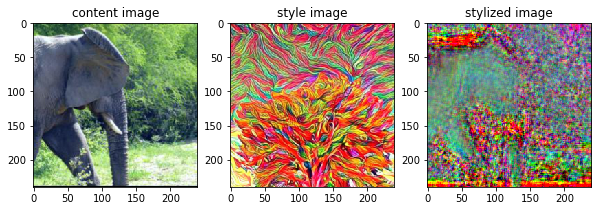

2017-12-15 15:03:01.206509 : 2500 iteration
style loss : 31.057327, content loss : 17.850351, tv loss : 0.806719


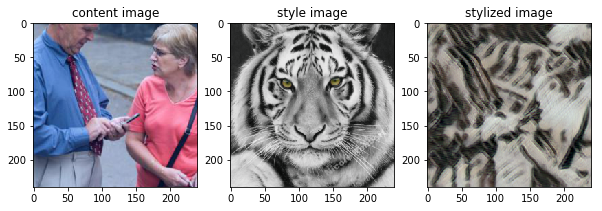

2017-12-15 15:32:34.419681 : 5000 iteration
style loss : 33.841438, content loss : 21.145683, tv loss : 0.722394


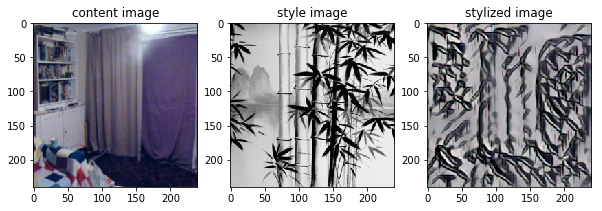

2017-12-15 16:01:59.634836 : 7500 iteration
style loss : 12.719624, content loss : 12.122425, tv loss : 0.465417


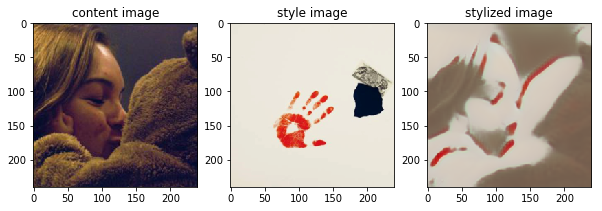

2017-12-15 16:31:16.062243 : 10000 iteration
style loss : 33.029499, content loss : 22.761457, tv loss : 0.726062


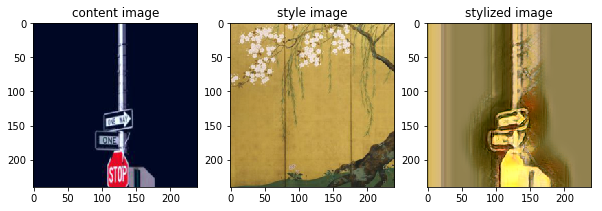

2017-12-15 16:35:19.482775 : 0 iteration
style loss : 11.178541, content loss : 13.344269, tv loss : 0.431827


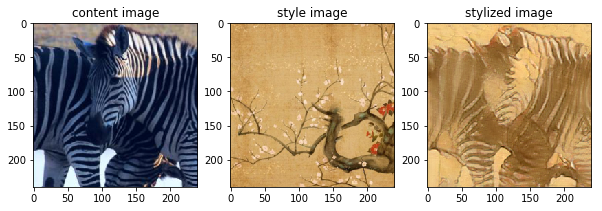

2017-12-15 17:04:44.717018 : 2500 iteration
style loss : 11.323209, content loss : 13.174015, tv loss : 0.505030


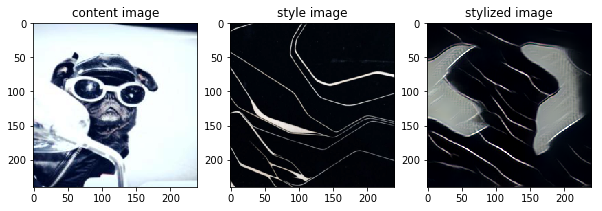

2017-12-15 17:33:36.428922 : 5000 iteration
style loss : 14.706044, content loss : 14.035606, tv loss : 0.539121


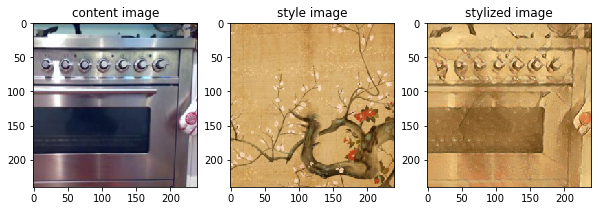

2017-12-15 18:02:48.652686 : 7500 iteration
style loss : 20.378450, content loss : 18.395491, tv loss : 0.626318


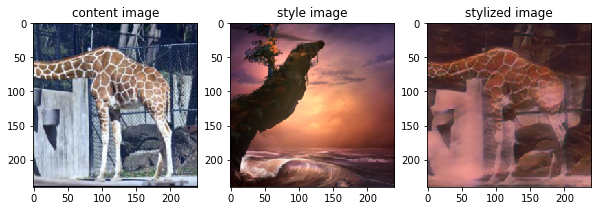

2017-12-15 18:31:54.302576 : 10000 iteration
style loss : 14.975628, content loss : 13.828456, tv loss : 0.620582


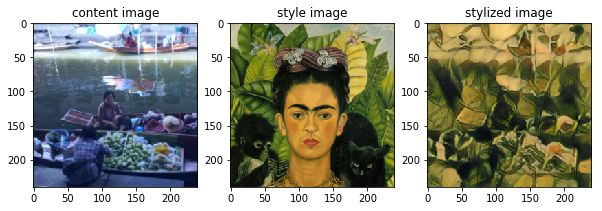

2017-12-15 18:35:59.306834 : 0 iteration
style loss : 9.924415, content loss : 14.603660, tv loss : 0.843682


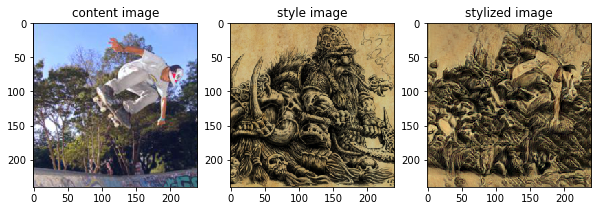

2017-12-15 19:05:30.748518 : 2500 iteration
style loss : 11.626509, content loss : 15.757689, tv loss : 0.653271


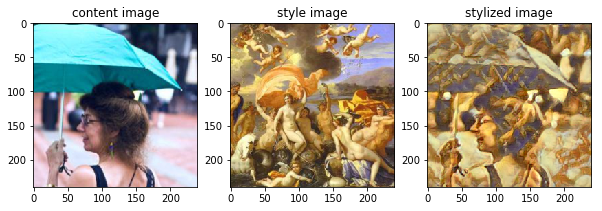

2017-12-15 19:34:22.480256 : 5000 iteration
style loss : 17.524107, content loss : 17.514872, tv loss : 0.679083


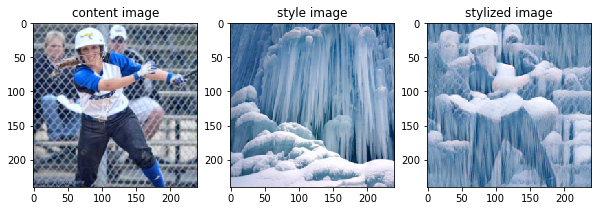

2017-12-15 20:03:19.254063 : 7500 iteration
style loss : 18.007992, content loss : 18.539335, tv loss : 0.571309


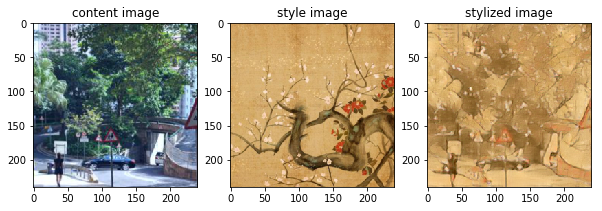

2017-12-15 20:32:20.842322 : 10000 iteration
style loss : 8.000447, content loss : 11.549293, tv loss : 0.581144


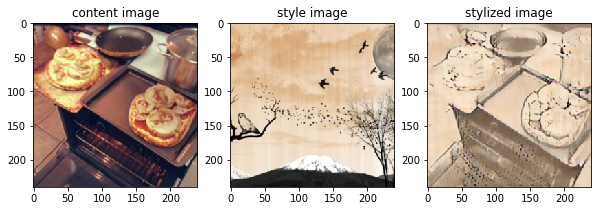

2017-12-15 20:36:19.189291 : 0 iteration
style loss : 9.266160, content loss : 9.877602, tv loss : 0.444603


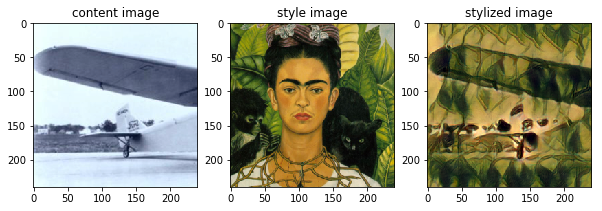

2017-12-15 21:05:21.807253 : 2500 iteration
style loss : 15.262691, content loss : 17.038147, tv loss : 0.693489


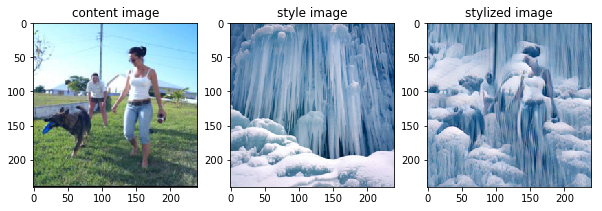

2017-12-15 21:34:40.253167 : 5000 iteration
style loss : 11.399055, content loss : 14.106783, tv loss : 0.595921


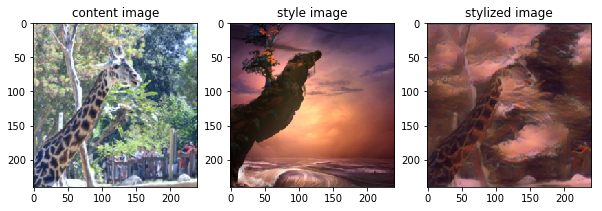

2017-12-15 22:03:42.963725 : 7500 iteration
style loss : 14.449131, content loss : 17.591490, tv loss : 0.847537


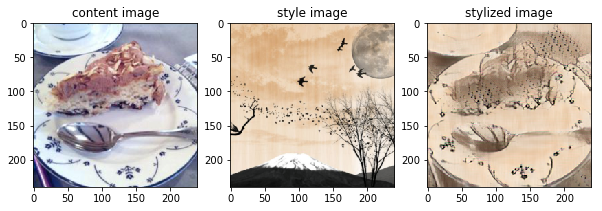

2017-12-15 22:33:05.050735 : 10000 iteration
style loss : 9.945733, content loss : 14.739363, tv loss : 0.586854


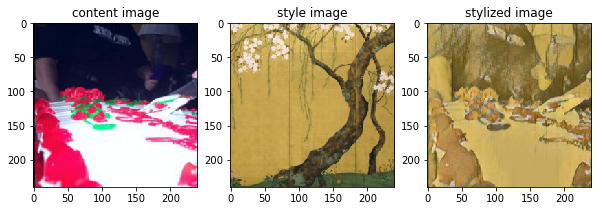

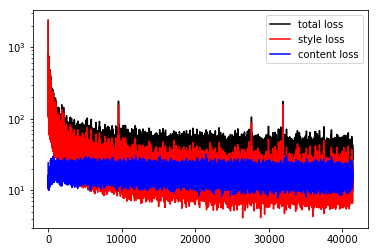

In [23]:
# train style transfer network
learned_model = learn_style_transfer_network(stn, vgg)